In [4]:
using Plots
using LinearAlgebra
using NumericalIntegration
using Distributions

In [5]:
using LaTeXStrings

# 1. Set the backend (GR is the default, fast, and handles this well)
gr()

# 2. Configure Global Settings for Retina + LaTeX Look
default(
    # Retina / High-DPI settings
    fmt = :png,         # PNG renders faster than SVG for complex plots
    dpi = 300,          # 300 DPI makes it crisp on Retina screens (standard is 72-100)
    
    # LaTeX Font settings
    fontfamily = "Computer Modern", # Use the standard LaTeX font
    guidefontsize = 12,             # Adjust font sizes for readability
    tickfontsize = 10,
    legendfontsize = 10
)

QUANTUM HARMONIC OSCILLATOR

In [93]:
"""
N -- Number of eigenfunctions to compute
"""
function harmonic_wavefunction(x, N)
    f_1 = 0
    f0 = (1 / π^0.25) * exp.(-0.5 * x.^2)
    eigenfunctions = Array{Float64,2}(undef, length(x), N+2)
    eigenfunctions[:,2] .= f0
    eigenfunctions[:,1] .= f_1
    for i in 3:N+1
        eigenfunctions[:,i] .= sqrt(2 / i) * x .* eigenfunctions[:,i-1] - sqrt((i - 1) / i) * eigenfunctions[:,i-2]
    end
    return eigenfunctions[:,2:end]
end

harmonic_wavefunction

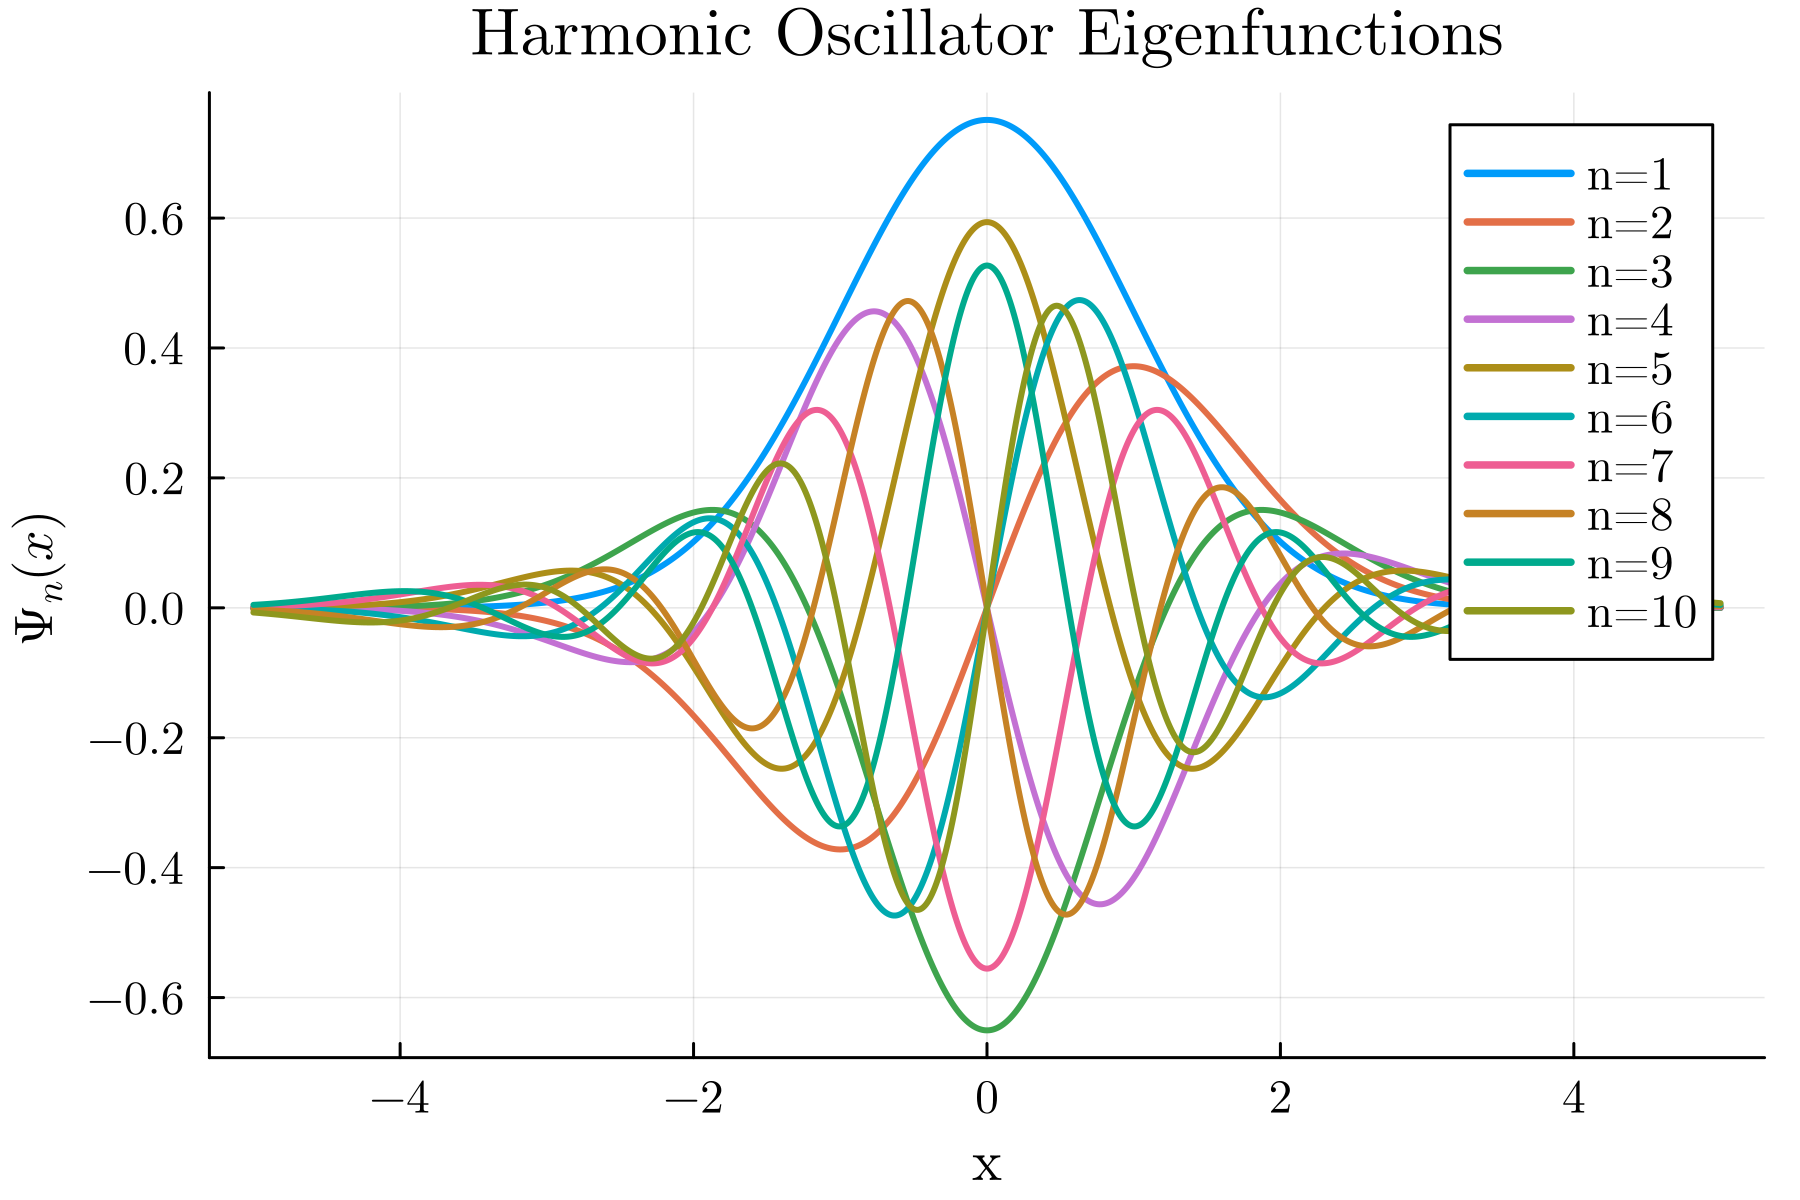

In [94]:
x = LinRange(-5, 5, 1000)
N = 10
eigenfunctions = harmonic_wavefunction(x, N)
plot()  # Create initial plot
for n in 1:N
    plot!(x, eigenfunctions[:,n], label="n=$n", lw=2)
end
plot!(title="Harmonic Oscillator Eigenfunctions", xlabel="x", ylabel=L"\Psi_n(x)")
display(plot!())

In [8]:
function harmonic_density(psi, E, n1, n2, beta)
    vec1 = psi[n1,:]
    vec2 = psi[n2,:]
    energy = exp.(-beta.*E)
    return dot(vec2, vec1 .* energy)
end

harmonic_density (generic function with 1 method)

In [9]:
function diagonal_harmonic_density(psi, E, beta, x)
    N = length(x)
    density = zeros(N)
    for i in 1:N
        density[i] = harmonic_density(psi, E, i, i, beta)
    end
    return density
end

diagonal_harmonic_density (generic function with 1 method)

In [10]:
function partition_function(psi, E, beta, x)
    integrande = diagonal_harmonic_density(psi, E, beta, x)
    method = SimpsonEven()
    return integrate(x, integrande, method)
end

partition_function (generic function with 1 method)

In [11]:
x = LinRange(-2, 2, 1000)
psi = harmonic_wavefunction(x, 50)
E = collect(0:50) .+ 0.5
beta = collect(0.5:0.5:2.0)

4-element Vector{Float64}:
 0.5
 1.0
 1.5
 2.0

In [12]:
for i in 1:length(beta)
    Z = partition_function(psi, E, beta[i], x)
    println("Partition function at beta=$(beta[i]) is Z=$Z")
end

Partition function at beta=0.5 is Z=1.2107317925642023
Partition function at beta=1.0 is Z=0.730810204164991
Partition function at beta=1.5 is Z=0.5173636764736552
Partition function at beta=2.0 is Z=0.3856023777817133


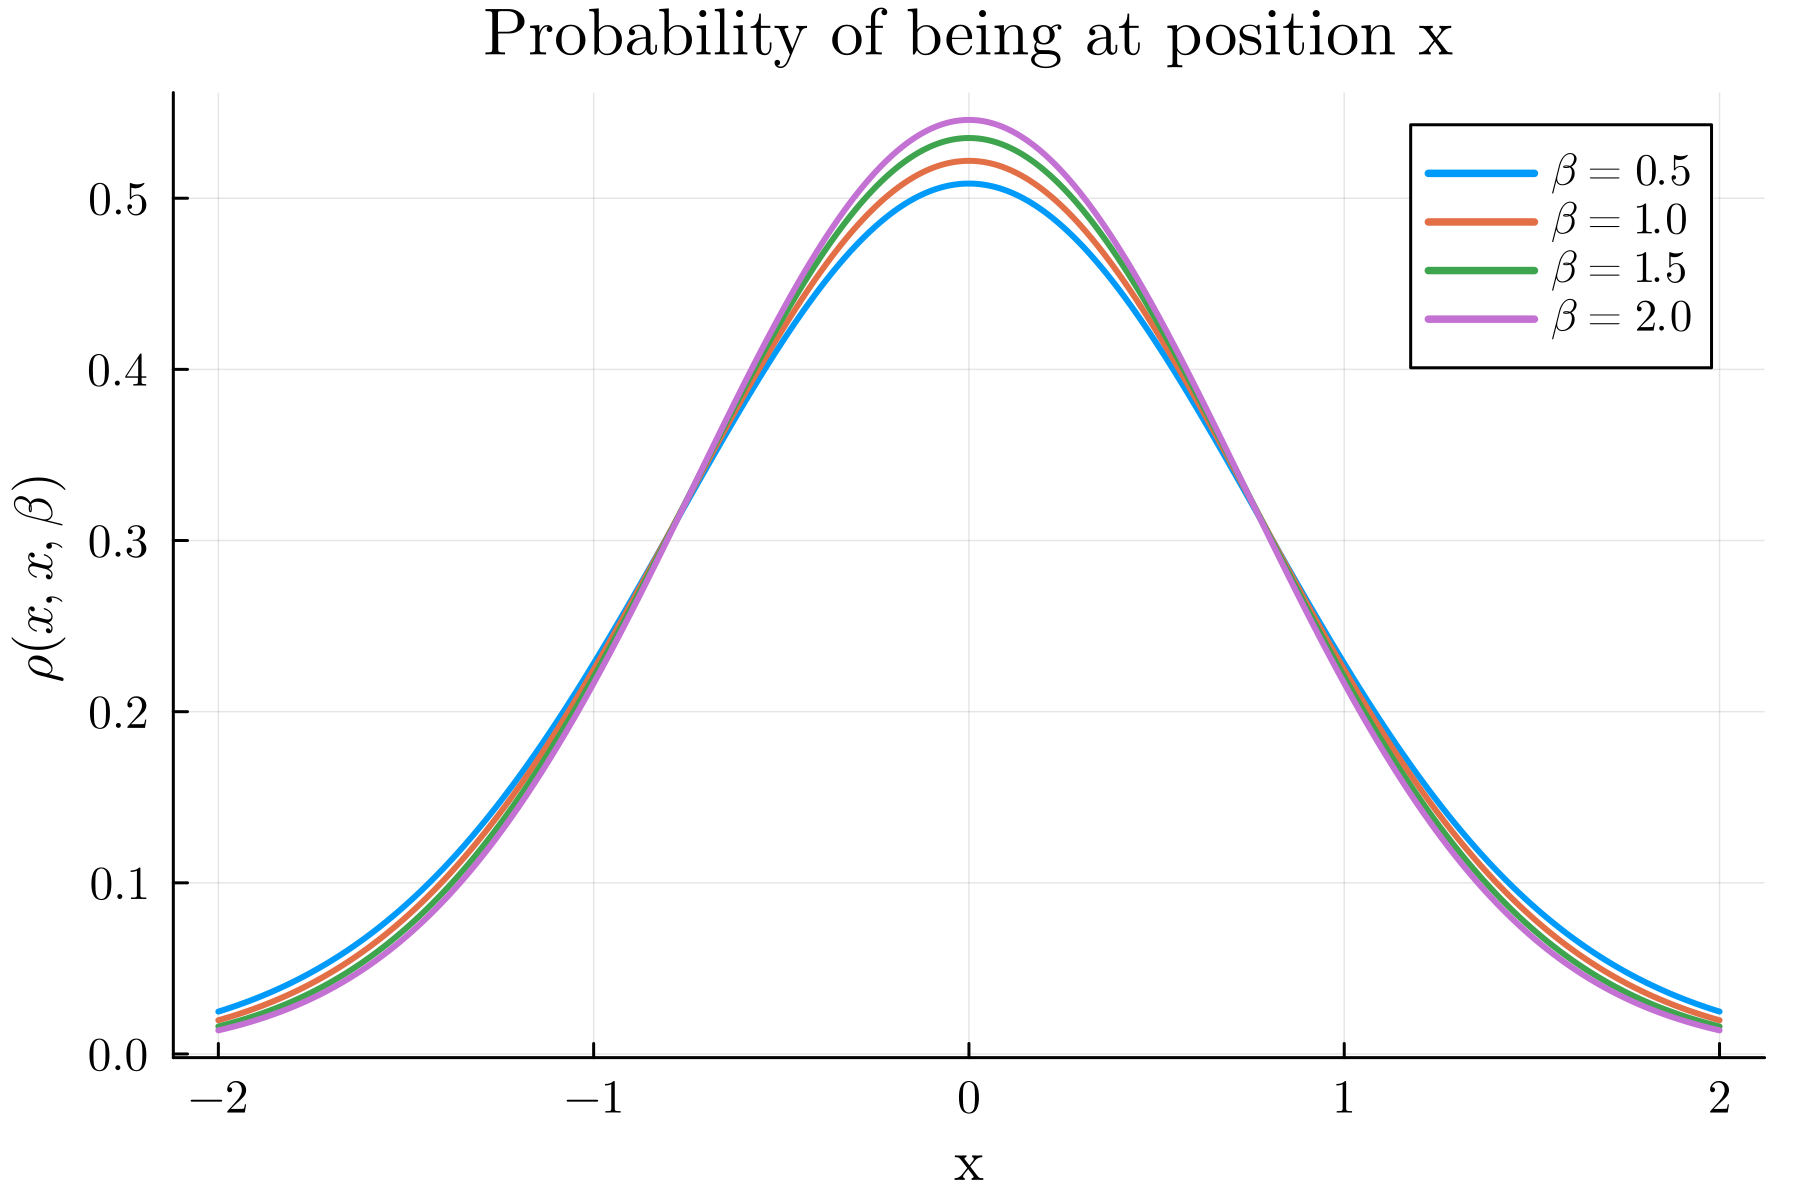

In [13]:
plot()
for i in 1:length(beta)
    density = diagonal_harmonic_density(psi, E, beta[i], x)
    Z = partition_function(psi, E, beta[i], x)
    density ./= Z  # Normalize the density
    plot!(x, density, label=L"\beta=%$(beta[i])", lw=2)
end
plot!(title="Probability of being at position x", xlabel="x", ylabel=L"\rho(x, x, \beta)")
display(plot!())

HIGH TEMPERATURE LIMIT CONVOLUTION

In [14]:
"""
The space grid x is supposed to be evenly spaced with n points.
"""
function matrix_square(x, rho, n)
    dx = x[2] - x[1]
    rho = rho * dx
    return (rho^n)
end

matrix_square

In [ ]:
function naive_harmonic_path(x, beta, delta, N_eigenvec)
    N_beads = length(x)
    y = copy(x)
    delta = beta/N_beads
    dist_bead = DiscreteUniform(1, N_beads)
    k = rand(dist_bead)
    dist_var = Uniform(-delta, delta)
    dist_ran = Uniform(0, 1)
    z = x[k] + rand(dist_var)
    y[k] = z
    E = collect(0:N_eigenvec) .+ 0.5
    count = 0

    phi = harmonic_wavefunction(y, N_eigenvec)
    psi = harmonic_wavefunction(x, N_eigenvec)
    pa = harmonic_density(psi, E, mod1(k-1, N_beads), k, beta)*harmonic_density(psi, E, k, mod1(k+1, N_beads), beta)*exp(-0.5*delta*x[k]^2)
    pb = harmonic_density(phi, E, mod1(k-1, N_beads), k, beta)*harmonic_density(phi, E, k, mod1(k+1, N_beads), beta)*exp(-0.5*delta*z^2)

    if rand(dist_ran) < pb/pa
        return y
    else
        return x
    end
end

naive_harmonic_path (generic function with 2 methods)

In [95]:
function naive_QMC(p)
    N_steps = p.N_steps
    beta = p.beta
    delta = p.delta
    N_eigenvec = p.N_eigenvec
    x = p.initial_path
    n_beads = length(x)
    paths = zeros(N_steps, n_beads)
    current_path = copy(x)
    paths[1, :] .= current_path
    count = 0

    for step in 2:N_steps
        current_path = naive_harmonic_path(current_path, beta, delta, N_eigenvec)
        paths[step, :] .= current_path
        if paths[step, :] == paths[step-1, :]
            count += 1
        end
    end

    return paths, count
end

naive_QMC (generic function with 1 method)

In [96]:
my_initial_path = randn(8)

p = (
    N_steps = 1000000,
    N_eigenvec = 20,
    beta = 4.0,
    delta = 0.5,
    initial_path = my_initial_path
)

(N_steps = 1000000, N_eigenvec = 20, beta = 4.0, delta = 0.5, initial_path = [1.086906949420688, -0.7609646168360021, 1.2832649151652704, 1.0370615798199958, 1.273571780385391, 1.8529494766585042, 0.4999686295231397, -0.7761710323571995])

In [97]:
hist, rejection = naive_QMC(p)

([1.086906949420688 -0.7609646168360021 … 0.4999686295231397 -0.7761710323571995; 1.086906949420688 -0.7609646168360021 … 0.9713110472433838 -0.7761710323571995; … ; 0.6074580512248687 0.07647163124901413 … 0.23731018150867944 -1.142411326554086; 0.6074580512248687 0.07647163124901413 … 0.23731018150867944 -1.142411326554086], 156069)

In [104]:
println("Rejection rate: $((rejection/p.N_steps)*100) %")

Rejection rate: 15.606900000000001 %


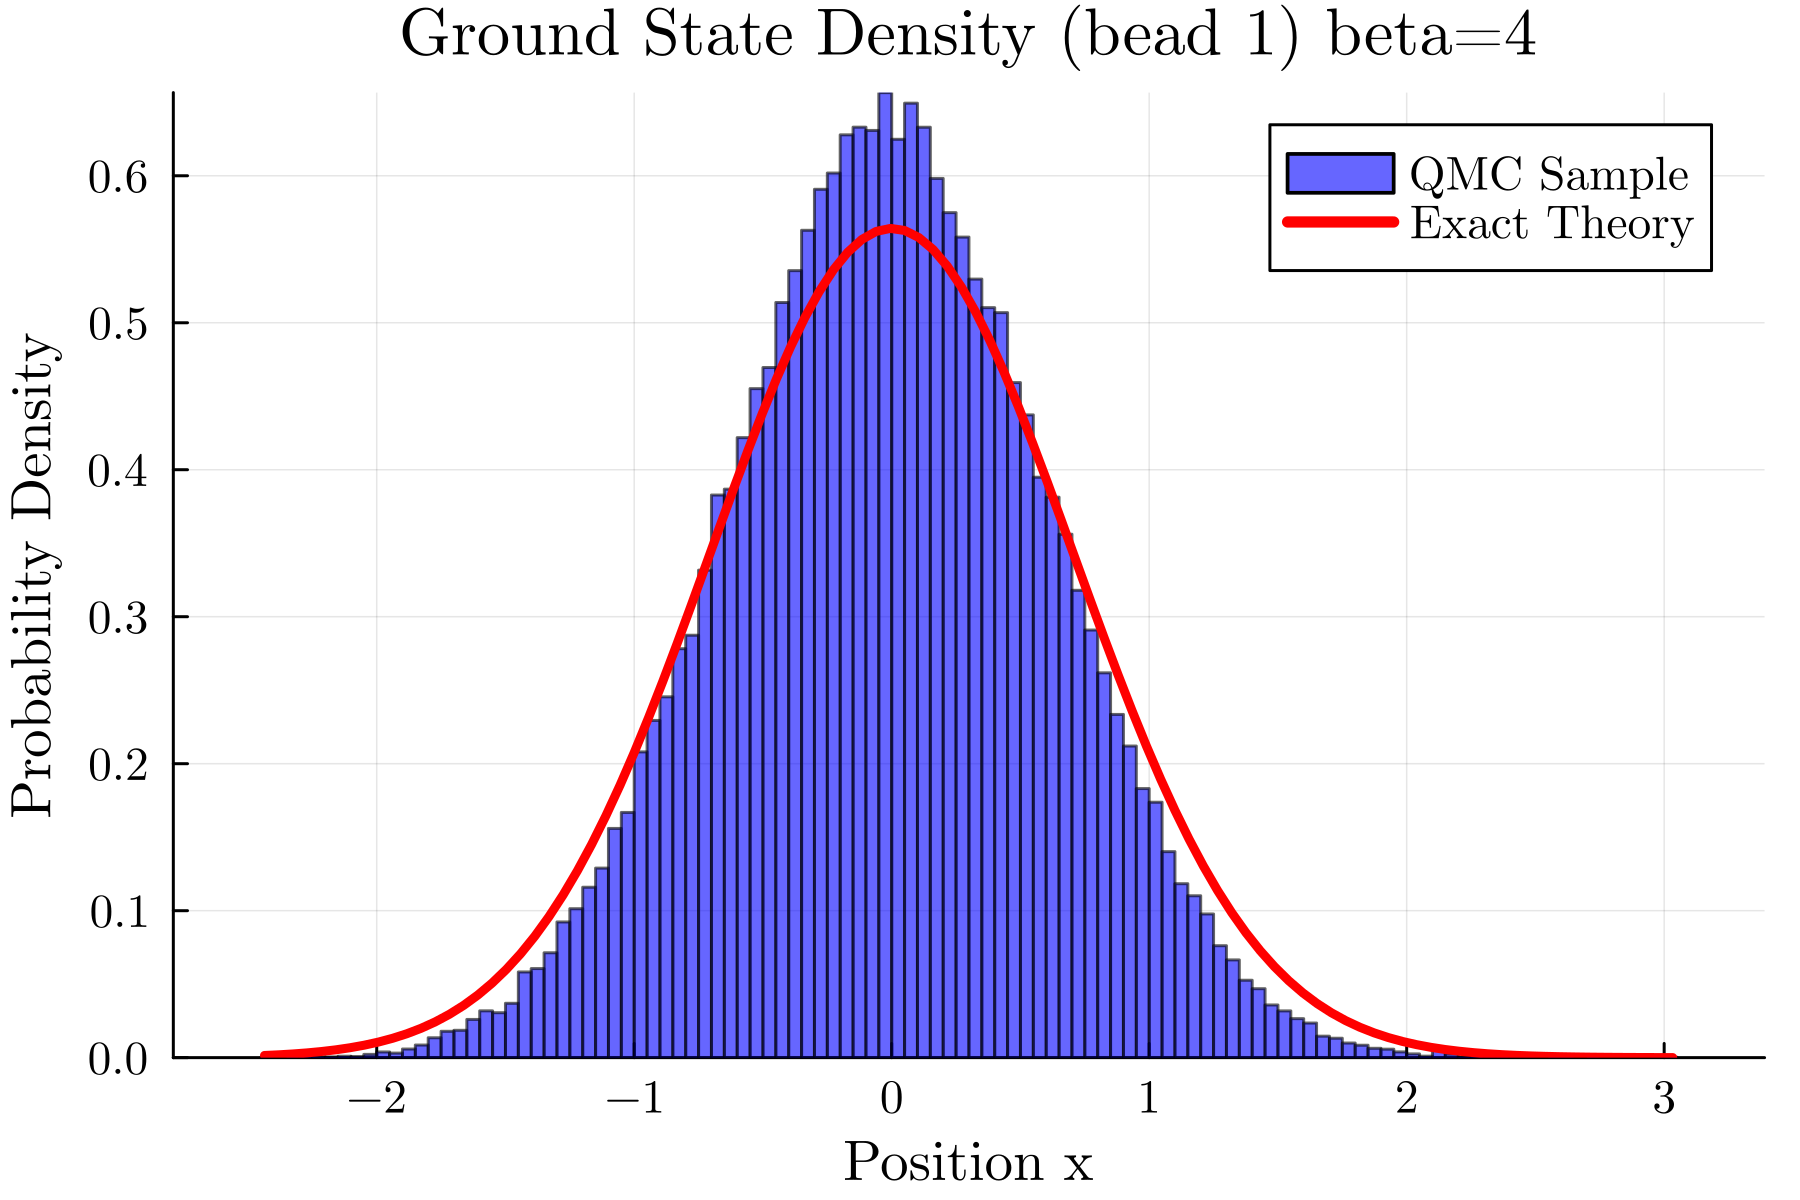

In [103]:
clean_history_x0 = hist[1000:end, 1]
histogram(clean_history_x0, 
    normalize = :pdf,       # Normalize area to 1 (to compare with theory)
    bins = 100,              # Number of bars
    label = "QMC Sample",
    color = :blue,
    alpha = 0.6,            # Transparency
    xlabel = "Position x",
    ylabel = "Probability Density",
    title = "Ground State Density (bead 1) beta=4"
)
x_grid = range(minimum(clean_history_x0), maximum(clean_history_x0), length=100)
psi_0(x) = (1/pi)^(1/4) * exp(-x^2 / 2)  # Standard Harmonic Oscillator ground state
plot!(x_grid, abs2.(psi_0.(x_grid)), 
    label = "Exact Theory", 
    lw = 3, 
    color = :red
)

DIRECT PATH SAMPLING AND THE LEVY CONSTRUCTION

In [48]:
function levy_free_path(start_bead, end_bead, N_beads, beta)
    step_time = beta/N_beads
    path = zeros(N_beads)
    path[1] = start_bead
    path[end] = end_bead

    for i in 2:N_beads-1
        delta = (N_beads-i)*step_time
        mean = (delta*path[i-1] + step_time*end_bead)/(delta + step_time)
        variance = (step_time*delta)/(step_time + delta)
        dist = Normal(mean, sqrt(variance))
        path[i] = rand(dist)
    end
    return path
end

levy_free_path (generic function with 1 method)

In [49]:
sample = levy_free_path(0.0, 0.0, 50000, 1.0)

50000-element Vector{Float64}:
  0.0
  0.0019181876134077794
  0.00016617937204856968
  0.008981851140920061
  0.005786450135140192
  0.006229313130477405
  0.01335856506265928
  0.01424448959388222
  0.020383233181655306
  0.02248395391921891
  0.019435294777949592
  0.01633881655626947
  0.017318838129736152
  ⋮
 -0.01106096116645065
 -0.01603797369208788
 -0.01699499297715306
 -0.014740447519841639
 -0.013456305162850802
 -0.010863205402092487
 -0.009989583891214675
 -0.009496361979214666
 -0.007419299380339901
 -0.0001261141424347874
 -0.0028865475526791973
  0.0

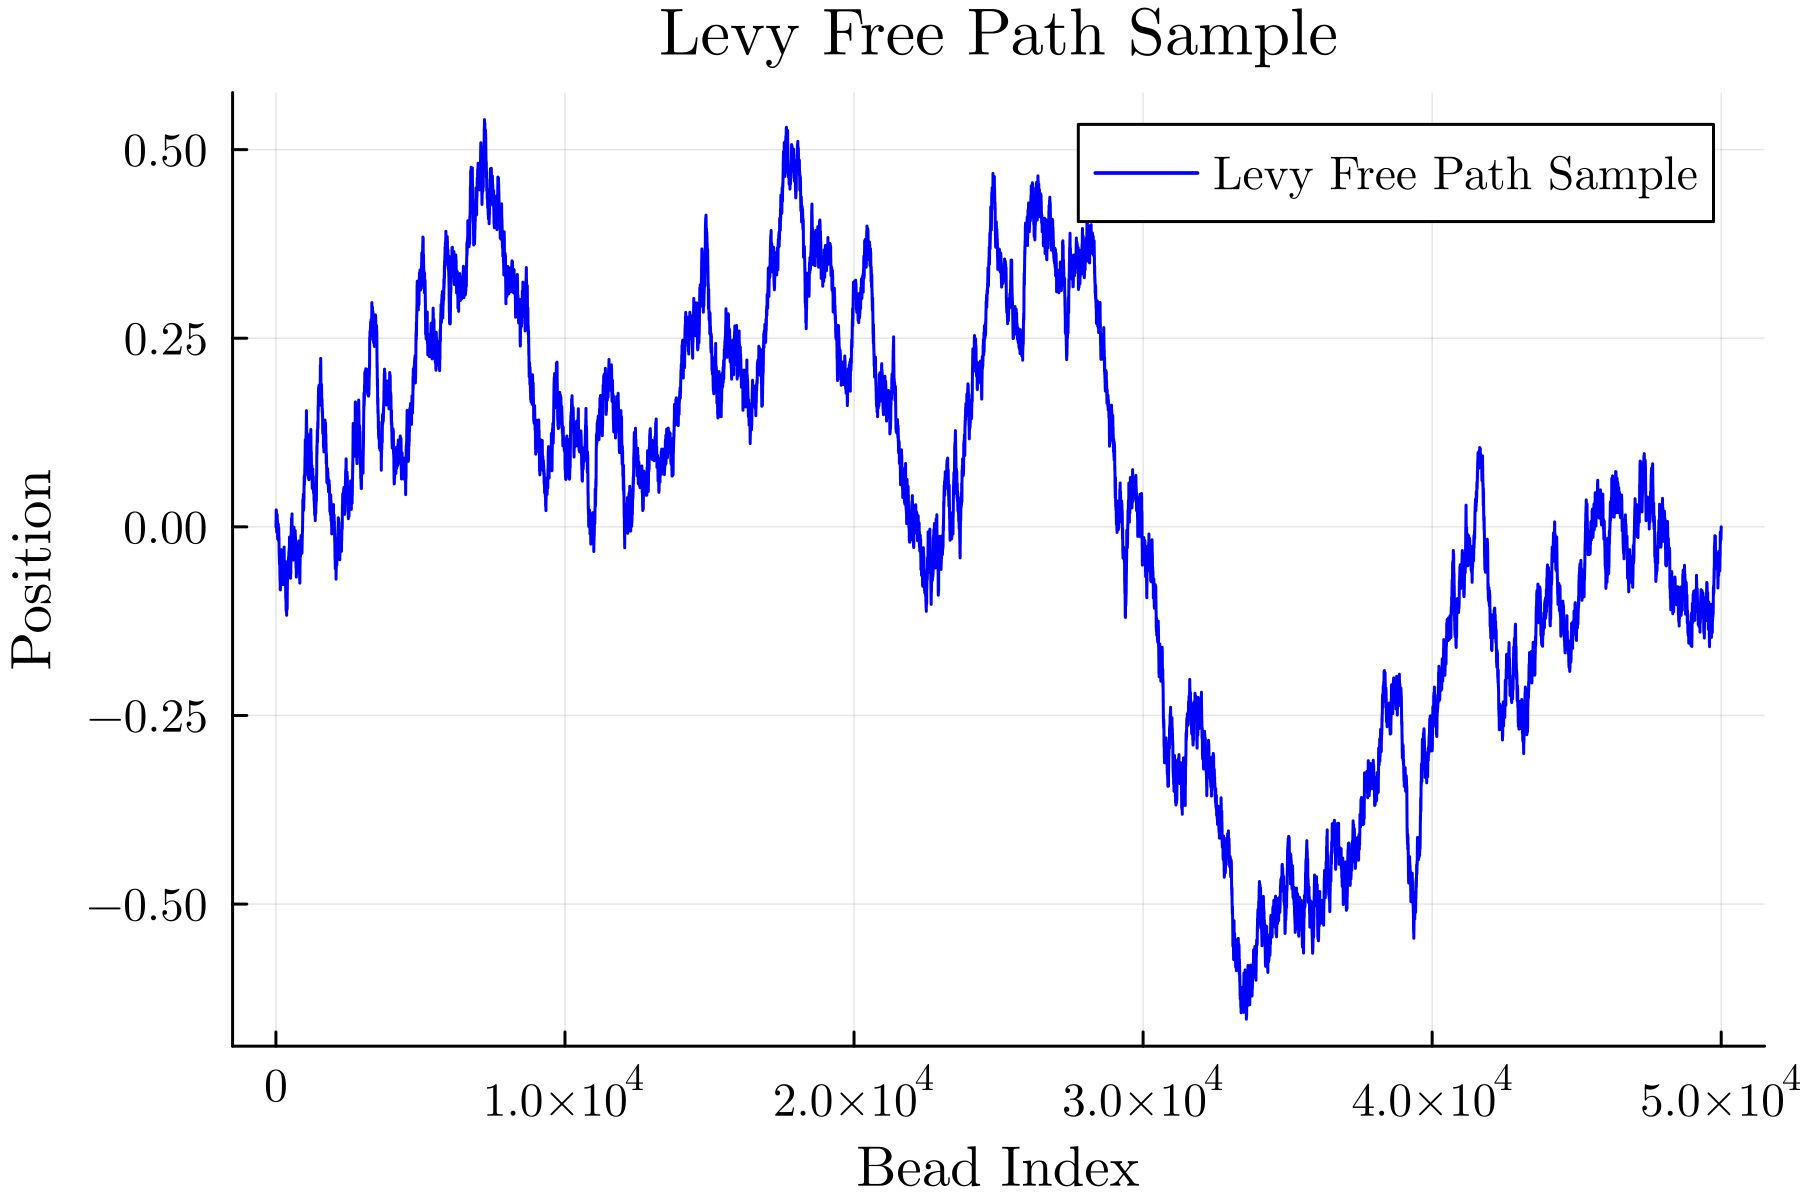

In [50]:
plot()
plot!(sample, lw=1, label="Levy Free Path Sample", color=:blue)
plot!(title="Levy Free Path Sample", xlabel="Bead Index", ylabel="Position")
display(plot!())    

In [51]:
function levy_harmonic_path(start_bead, end_bead, N_beads, beta)
    step_time = beta/N_beads
    path = zeros(N_beads)
    path[1] = start_bead
    path[end] = end_bead

    for i in 2:N_beads-1
        delta1 = coth(step_time*(N_beads - i)) + coth(step_time)
        delta2 = path[i-1]*csch(step_time*N_beads) + end_bead*csch(step_time*(N_beads - i))
        mean = delta2 / delta1
        variance = 1 / delta1
        dist = Normal(mean, sqrt(variance))
        path[i] = rand(dist)
    end
    return path
end
    

levy_harmonic_path (generic function with 1 method)

In [52]:
sample_harm = levy_harmonic_path(0.0, 0.0, 50000, 1.0)

50000-element Vector{Float64}:
  0.0
 -0.003783125231256526
 -0.002520062618187631
 -0.0007792268802130886
 -0.00028406451370872166
 -0.0004898938475398611
 -0.0007374800698322217
 -0.001686595512748212
 -0.0001356506032832992
  0.0018091372833077203
  0.0024387181363501372
 -0.0016813426679894979
  0.0036514263788393797
  ⋮
  0.005846722112499361
 -0.010671395184694421
  0.006058855768536135
  0.002559463387460766
  0.004270455121614534
 -0.002711240493652953
 -0.002439968426171221
  0.001585071737298255
  0.001436393333267593
  0.00125930479442211
  0.0008807096481192661
  0.0

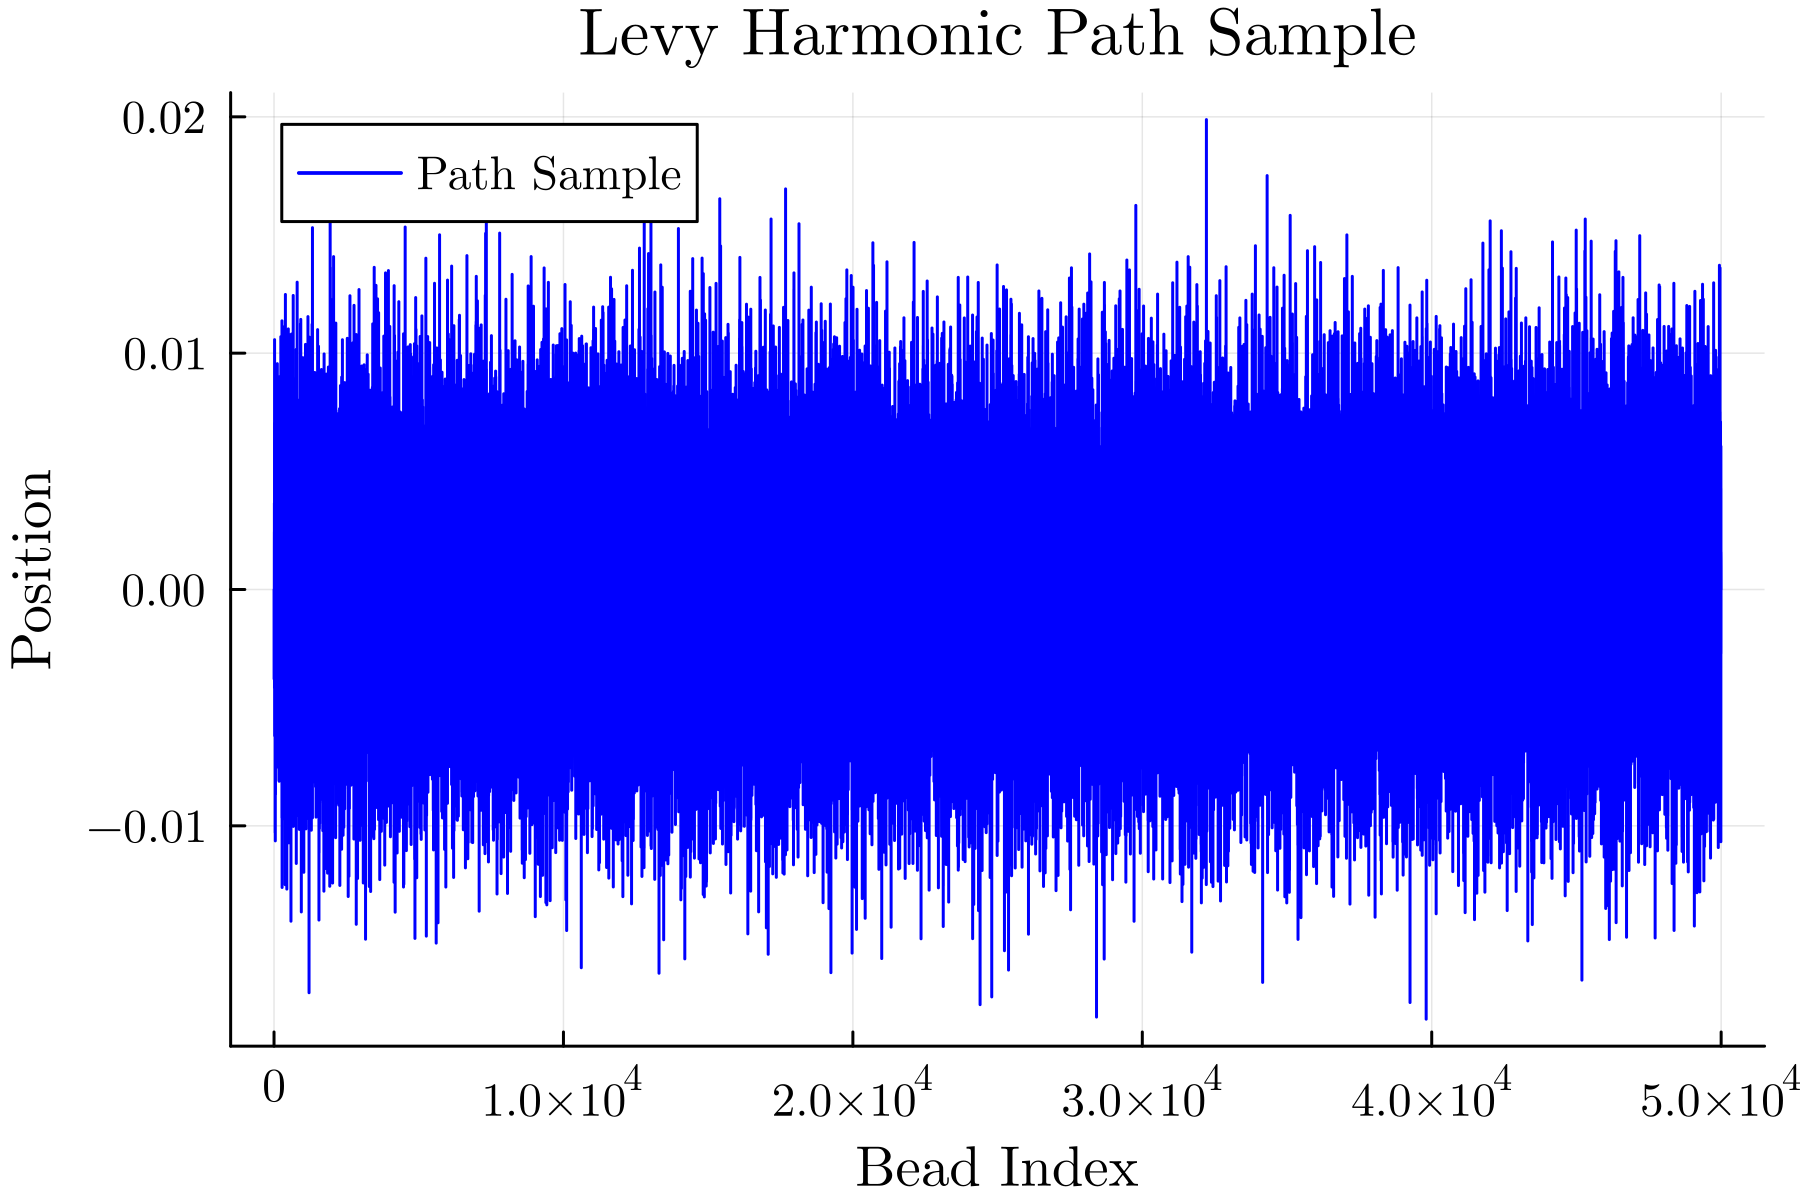

In [54]:
plot()
plot!(sample_harm, lw=1, label="Path Sample", color=:blue)
plot!(title="Levy Harmonic Path Sample", xlabel="Bead Index", ylabel="Position")
display(plot!())    

PERIODIC BOUNDARY CONDITIONS, PATHS IN A BOX

In [55]:
function naive_box_path(start_bead, end_bead, N_beads, beta, L)
    K = N_beads//2
    if N_beads % 2 != 0
        throw(ArgumentError("Number of beads should be divisible by 2, but got $N_beads"))
    end
    if abs(start_bead) > L/2 || abs(end_bead) > L/2
            throw(ArgumentError("Bead positions must be within the box of size L=$L"))
        end
    for i in 1:K
        delta_k = 2^i
        delta = beta/delta_k
        for j in 1:N_beads/delta_k
            pplus = (j+1)*delta_k
            pmoins = (j-1)*delta_k
            mean = (path[pmoins] + path[pplus]) / 2
            variance = 2/delta
            dist = Normal(mean, sqrt(variance))
            z = rand(dist)
            if z>L || z<0
                path[j*delta_k] = path[j*delta_k]
            else
                path[j*delta_k] = z
            end
        end
    end
    return path
end

naive_box_path (generic function with 1 method)

PATH IN FOURIER SPACE

In [61]:
function fourier_free_path(beta, N_beads)
    path = zeros(N_beads)
    coeffs = zeros(N_beads)
    for i in 1:N_beads
        var = 2*N_beads^2*sin(pi*i/(2*N_beads))^2
        coeffs[i] = (beta/var)^(1/2)*randn()
    end
    for k in 1:N_beads
        path[k] = sum(coeffs[j]*sin(pi*j*(k-1/2)/N_beads) for j in 1:N_beads)
    end
    return path
end

fourier_free_path (generic function with 1 method)

In [62]:
sample_tf = fourier_free_path(1.0, 50000)

50000-element Vector{Float64}:
  0.003095120715326031
 -0.0018129190172115597
 -0.00303507191244578
 -0.0027287691844422165
 -0.0037502699594899307
 -0.0016913983491505886
  0.003599771352283996
  0.008312201122819326
  0.0026560254933074286
 -0.006145500288615329
 -0.007589242265159233
  0.0013520749066932157
  0.0013211091941902964
  ⋮
  0.008593489540861792
  0.012388935968006177
  0.01962661598633484
  0.014714237370835955
  0.007492135151917123
  0.005640454694621349
  0.0026699485944699
  0.006365687260632982
 -0.0002442644108159399
  0.00361923080331358
  0.0014282704302550112
 -0.0037545092008669082

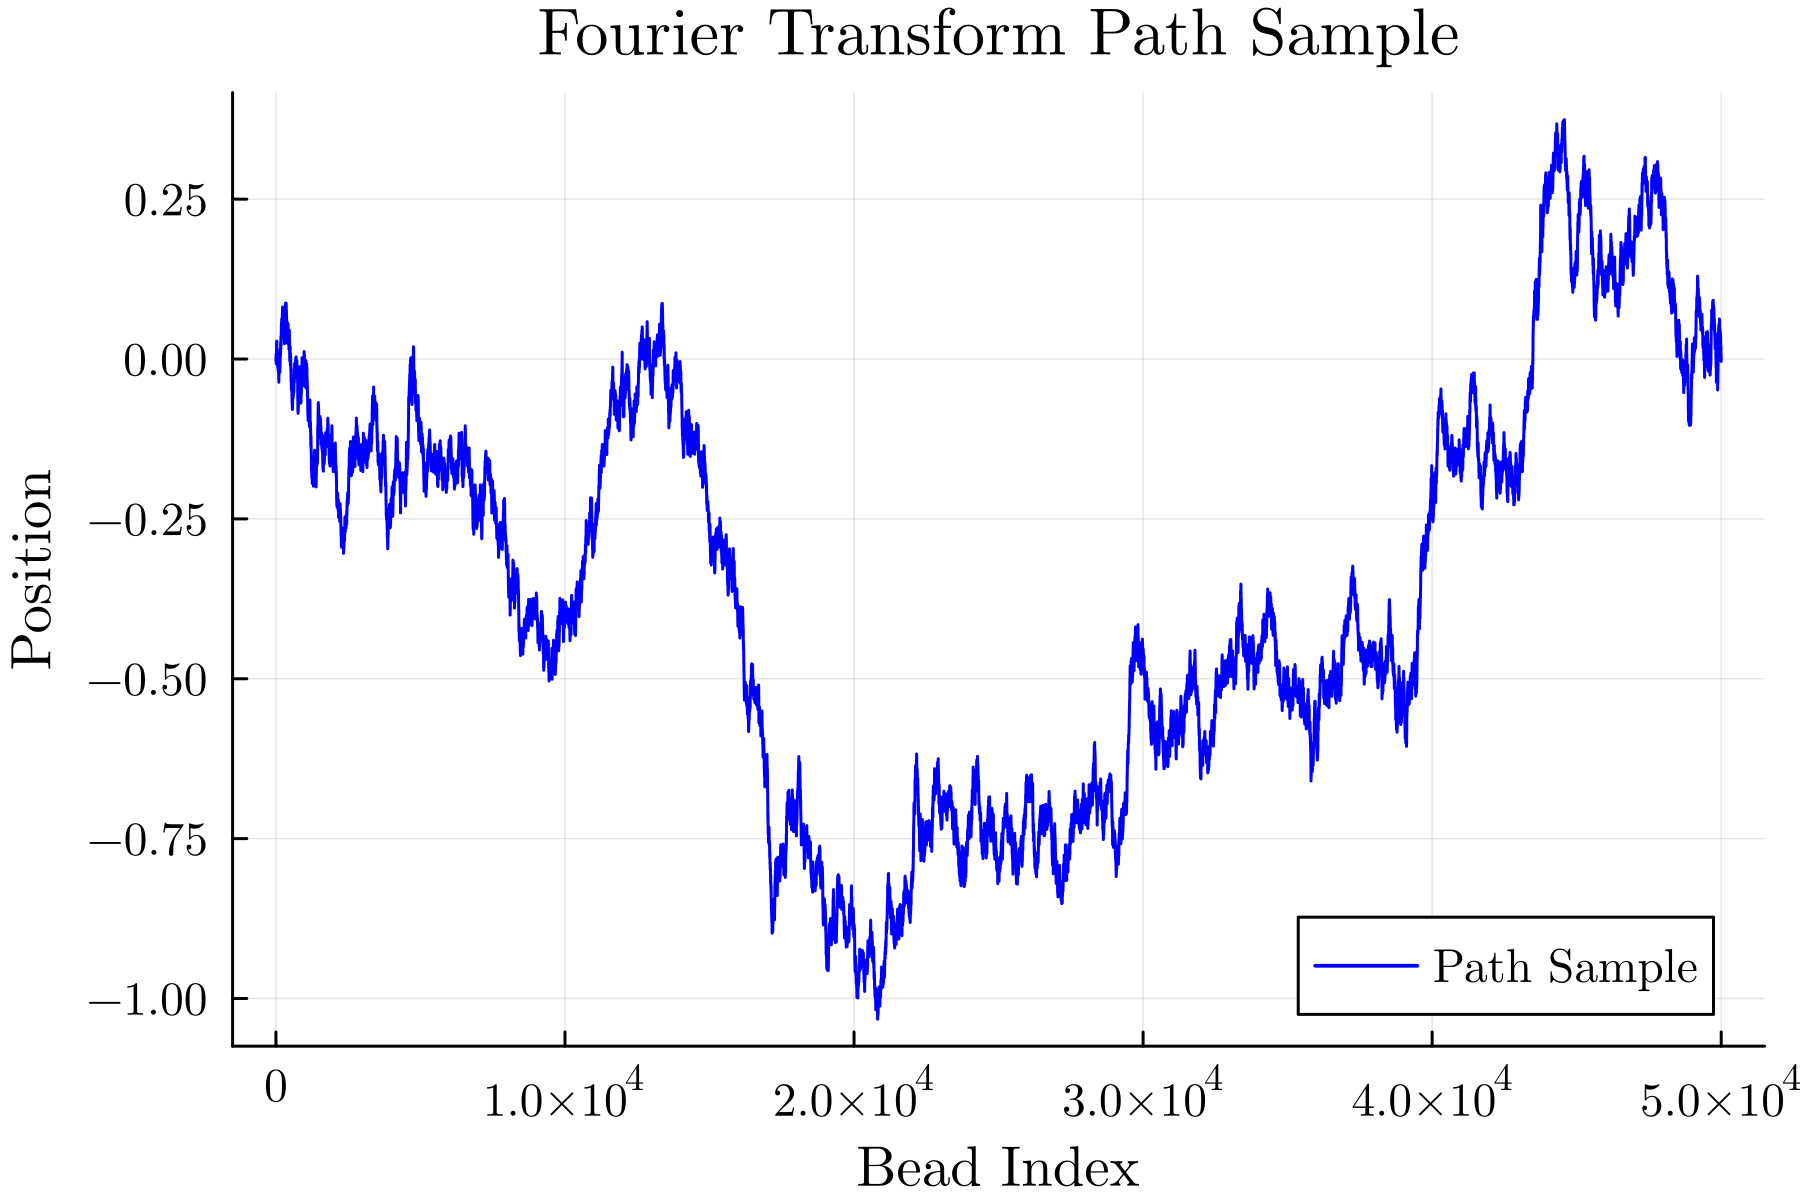

In [63]:
plot()
plot!(sample_tf, lw=1, label="Path Sample", color=:blue)
plot!(title="Fourier Transform Path Sample", xlabel="Bead Index", ylabel="Position")
display(plot!())   

CLASSICAL RANDOM PATH

In [76]:
function fourier_gen_path(N_beads, cutoff, roughness, L)
    A = []
    B = []
    path = []
    for i in 1:cutoff
        std = sqrt(1/(pi*i))*(L/(2*pi*i))^roughness
        push!(A, std*randn())
        push!(B, std*randn())
    end
    for i in collect(0:L/N_beads:L)
        sum = 0.0
        for j in 1:cutoff
            sum += A[j]*cos(2*pi*j*i/L) + B[j]*sin(2*pi*j*i/L)
        end
        push!(path, sum)
    end
    return path
end

fourier_gen_path (generic function with 3 methods)

In [89]:
sample_rand = fourier_gen_path(50000, 40, 1.5, 1.0)

50001-element Vector{Any}:
 -0.027710687991335775
 -0.027705438749421527
 -0.02770018622224396
 -0.027694930404531002
 -0.02768967129101537
 -0.02768440887643472
 -0.02767914315553156
 -0.027673874123053496
 -0.02766860177375318
 -0.027663326102388423
 -0.02765804710372227
 -0.027652764772523097
 -0.02764747910356456
  ⋮
 -0.027768214337437223
 -0.027763000884155287
 -0.02775778420390071
 -0.027752564291353088
 -0.02774734114119594
 -0.027742114748117032
 -0.027736885106808294
 -0.027731652211965843
 -0.027726416058290203
 -0.02772117664048634
 -0.027715933953263584
 -0.027710687991335796

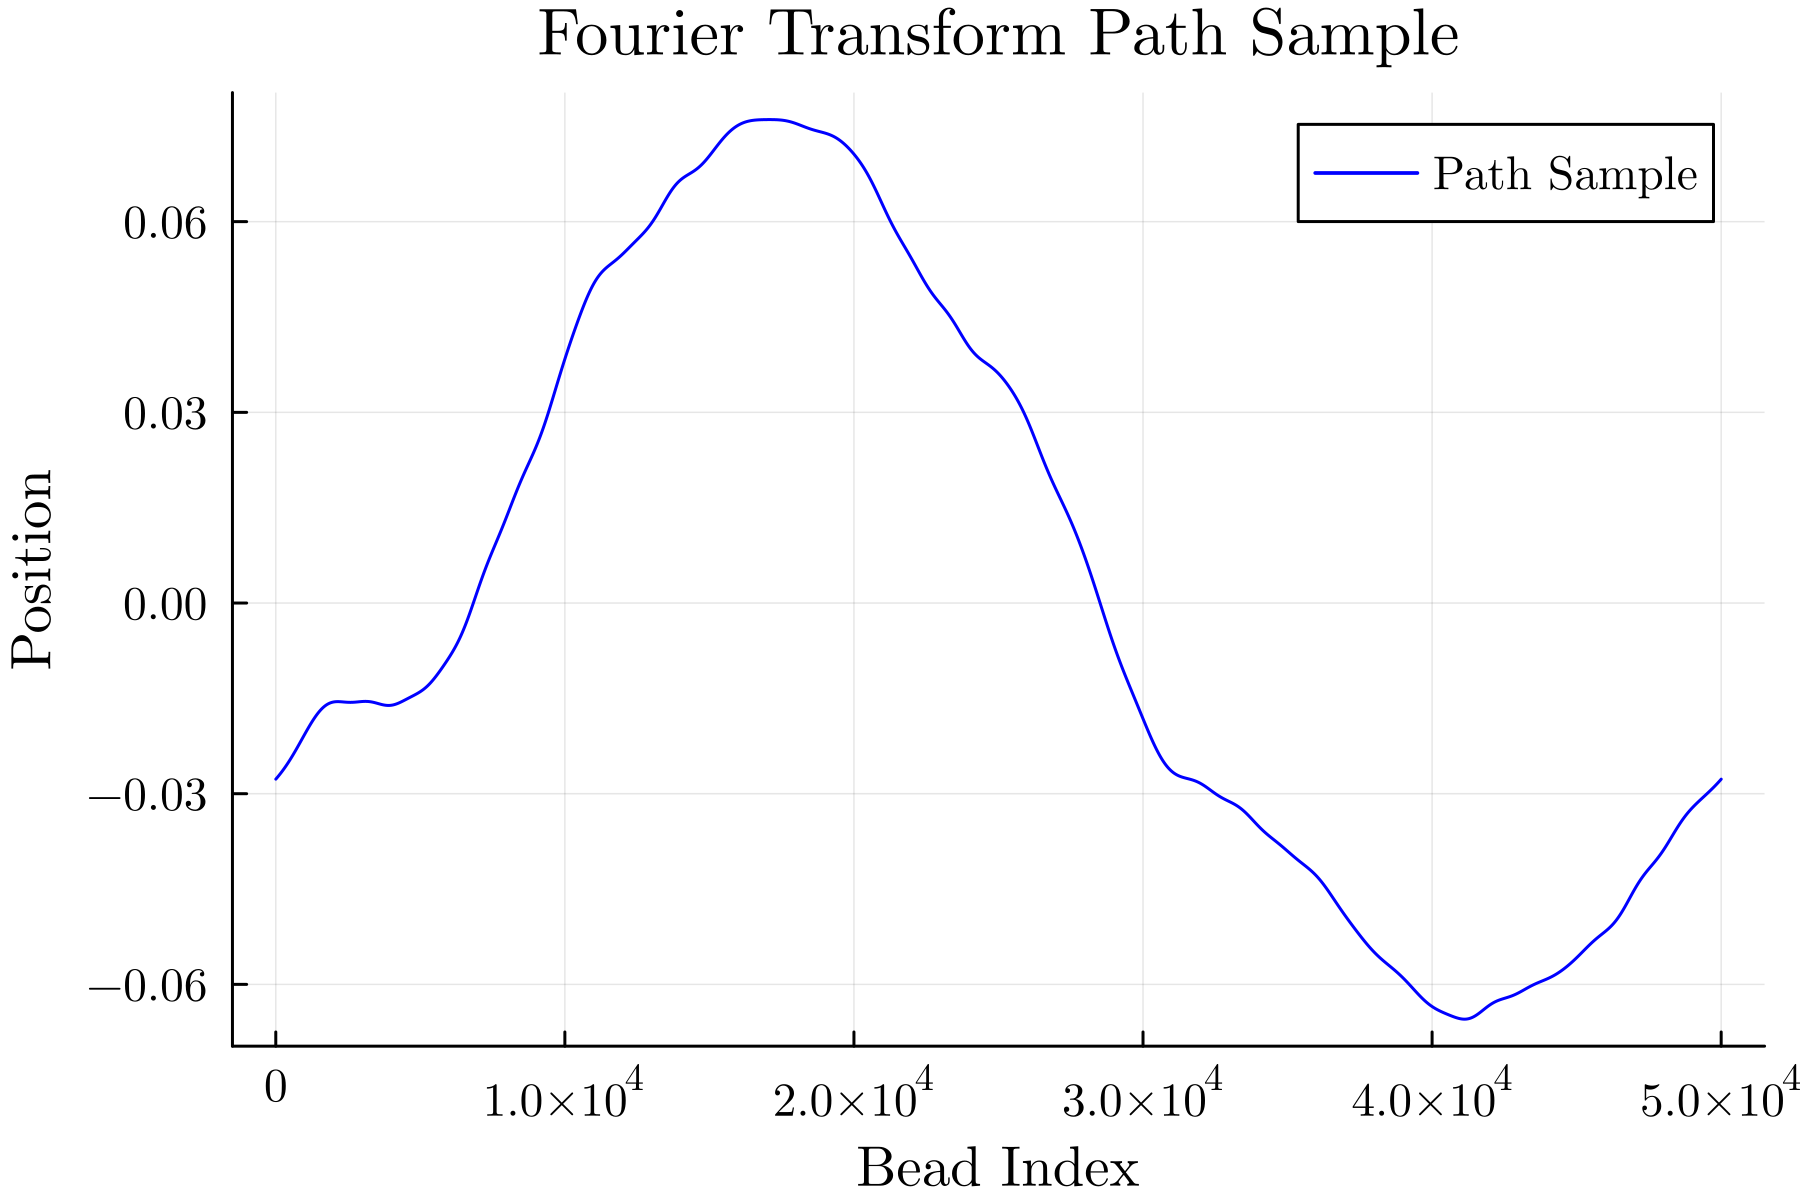

In [90]:
plot()
plot!(sample_rand, lw=1, label="Path Sample", color=:blue)
plot!(title="Fourier Transform Path Sample", xlabel="Bead Index", ylabel="Position")
display(plot!())   